In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import urllib.request
import zipfile
from PIL import Image
import io
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [2]:
# Define URL and paths for the new dataset
url = 'https://github.com/dekwannn/skripsi/archive/refs/heads/main.zip'
zip_path = 'penyakit_dataset.zip'
extract_path = 'penyakit_dataset'

# Download the dataset zip file
urllib.request.urlretrieve(url, zip_path)

# Unzip the downloaded file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define the new data directory after extraction
data_dir = os.path.join(extract_path, 'skripsi-main/ML/penyakit_ds')

In [3]:
# Create a list of filepaths and labels
filepaths = []
labels = []
classlist = os.listdir(data_dir)
for kelass in classlist:
    classpath = os.path.join(data_dir, kelass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(kelass)

# Create a DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

print(df.head())
print(df['labels'].value_counts())

                                           filepaths   labels
0  penyakit_dataset/skripsi-main/ML/penyakit_ds/R...  Rosacea
1  penyakit_dataset/skripsi-main/ML/penyakit_ds/R...  Rosacea
2  penyakit_dataset/skripsi-main/ML/penyakit_ds/R...  Rosacea
3  penyakit_dataset/skripsi-main/ML/penyakit_ds/R...  Rosacea
4  penyakit_dataset/skripsi-main/ML/penyakit_ds/R...  Rosacea
labels
acne         927
oily         803
Rosacea      399
Carcinoma    399
Keratosis    399
Milia        399
Eczema       399
Name: count, dtype: int64


In [4]:
# Splitting data into train, validation, and test sets
train_split = .8
test_split = .1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))

# Preprocessing dataset
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
print('test batch size:', test_batch_size, 'test steps:', test_steps)

train_df length: 2980 test_df length: 372 valid_df length: 373
test batch size: 62 test steps: 6


In [5]:
# Data augmentation
gen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

Found 2980 validated image filenames belonging to 7 classes.
Found 373 validated image filenames belonging to 7 classes.
Found 372 validated image filenames belonging to 7 classes.
['Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea', 'acne', 'oily']


In [6]:
# Build the model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)

model = Sequential([
    extractor,  # Feature extractor
    Conv2D(filters=32, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=64, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Train the model
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=valid_gen,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.3294 - loss: 2.5893 - val_accuracy: 0.6568 - val_loss: 0.9955
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.6086 - loss: 1.0750 - val_accuracy: 0.7587 - val_loss: 0.7266
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.6981 - loss: 0.8418 - val_accuracy: 0.7855 - val_loss: 0.6323
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.7498 - loss: 0.7164 - val_accuracy: 0.8445 - val_loss: 0.4827
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.7909 - loss: 0.5971 - val_accuracy: 0.8552 - val_loss: 0.4681
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.8165 - loss: 0.5404 - val_accuracy: 0.8660 - val_loss: 0.4419
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.8145 - loss: 0.5425 - val_accuracy: 0.8660 - val_loss: 0.3983
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.8272 - loss: 0.5087 - val_accuracy: 0.9008 - val_loss: 0.

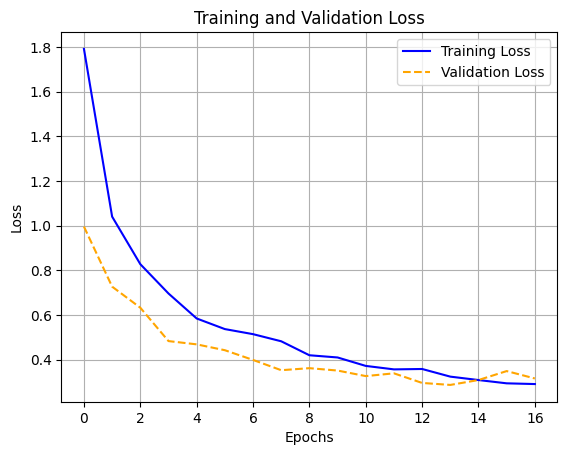

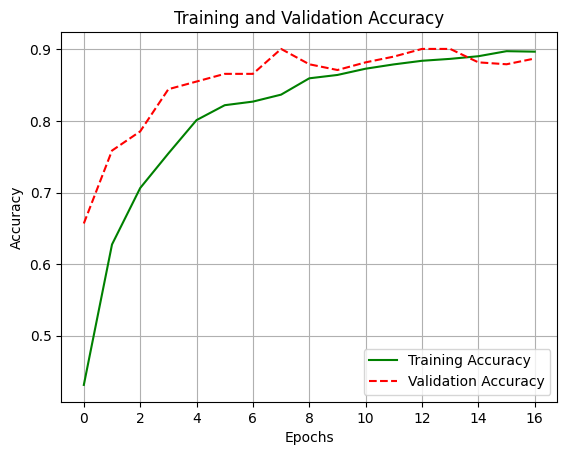

In [8]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Save the trained model as HDF5 file
model.save('skin_disease_model.keras')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('skin_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpgz6riucj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134396029781088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134396029780560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134396029781968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134396029782496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134396029781264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134396029788480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134396029788128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134396029791824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134396029789184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134396029790064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1343960297

In [10]:
from tensorflow.keras.preprocessing import image

# Define the classes
classes = ["Carcinoma", "Eczema", "Keratosis", "Milia", "Rosacea", "acne", "oily"]

In [11]:
# Function to preprocess the image
def preprocess_image(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array = img_array / 255.0  # Rescale image
    return img_array

# Function to predict the class of the image
def predict_image_class(model, img):
    img_array = preprocess_image(img)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    class_name = classes[predicted_class[0]]
    confidence = np.max(predictions) * 100
    return class_name, confidence

# Function to display the image with predicted class and confidence
def display_prediction(img, class_name, confidence):
    plt.imshow(img)
    plt.title(f"Predicted: {class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


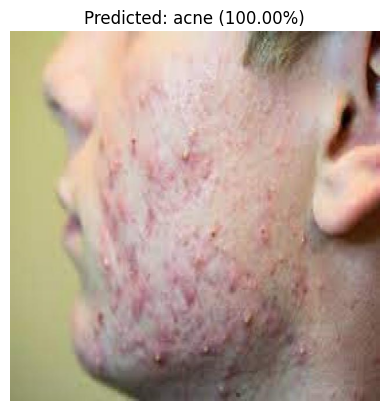

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


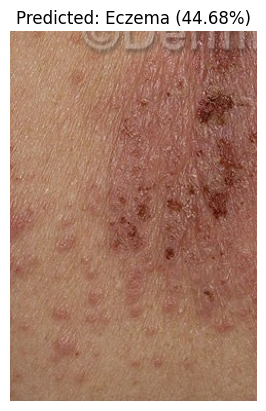

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


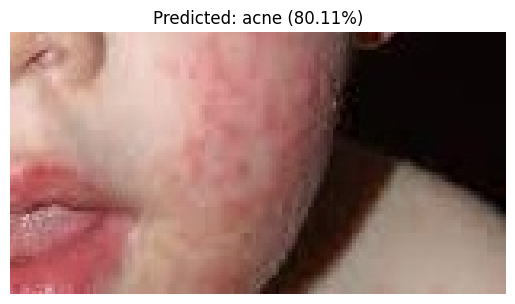

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


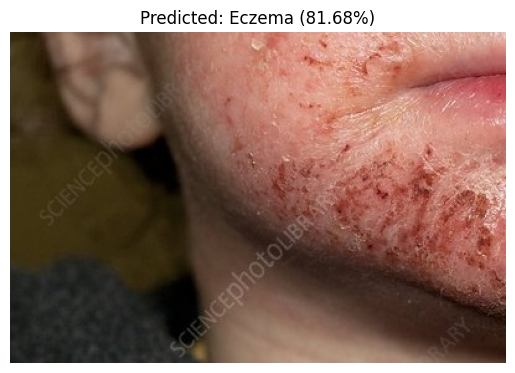

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


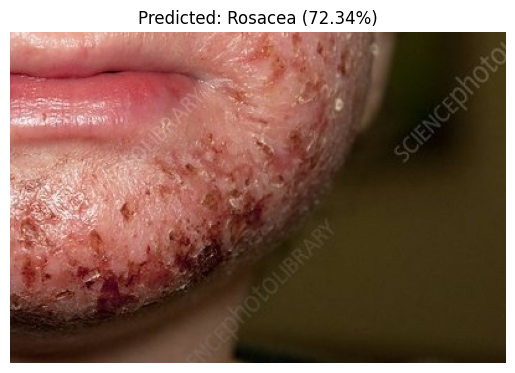

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


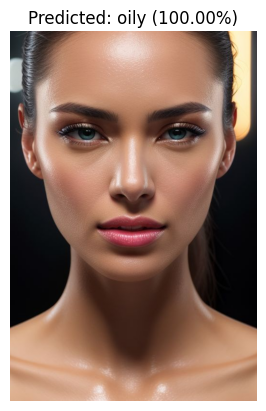

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


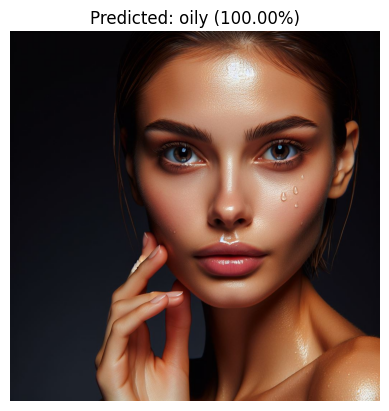

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


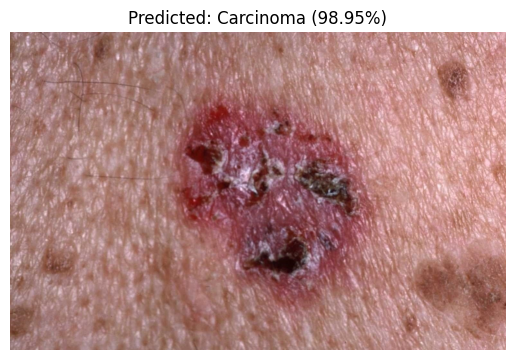

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


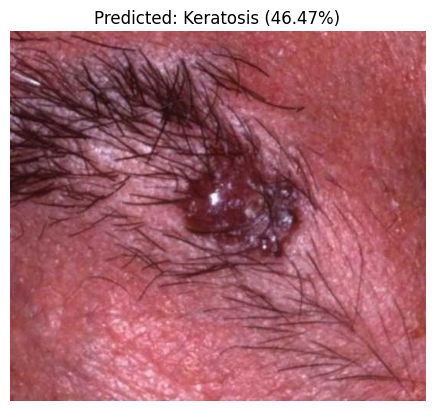

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


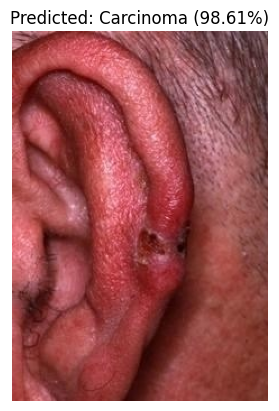

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


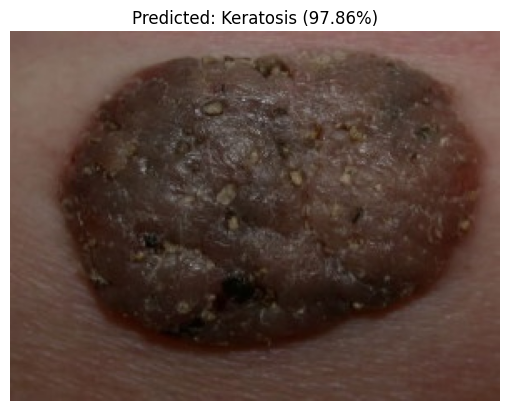

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


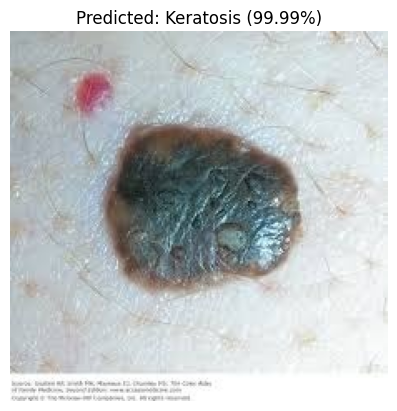

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


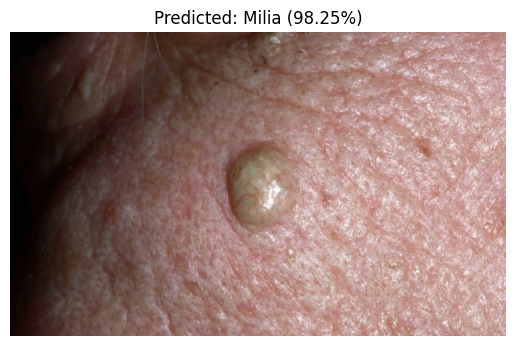

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


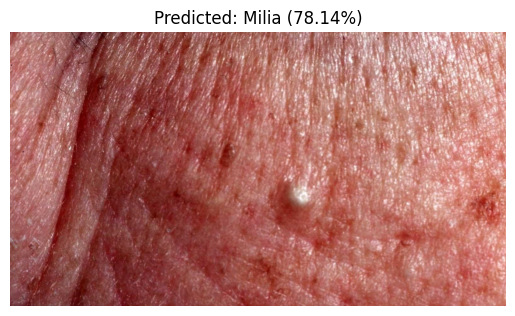

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


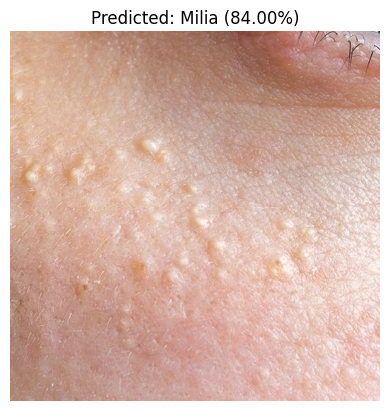

In [12]:
# Create a file upload widget
import ipywidgets as widgets
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    # Get the uploaded file
    file = next(iter(upload_widget.value.values()))
    content = file['content']

    # Open the image
    img = Image.open(io.BytesIO(content))

    # Predict the class of the image
    class_name, confidence = predict_image_class(model, img)

    # Display the image and prediction
    display_prediction(img, class_name, confidence)

# Observe the upload widget for changes
upload_widget.observe(on_upload_change, names='value')

# Display the upload widget
display(upload_widget)